In [1]:
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import tldextract   # Accurately separates a URL's subdomain, domain, and public suffix
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import re
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix,precision_score,recall_score,accuracy_score,classification_report,f1_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import nltk 
import spacy
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
import copy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,LancasterStemmer
from sklearn.metrics import f1_score
from pprint import pprint
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 1000)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data_path="input_dataset//ISOT_News_dataset//"

In [13]:
#### Creating the dataframes for fake and real dataset

In [14]:
fake_df=pd.read_csv(data_path+'Fake.csv')
real_df=pd.read_csv(data_path+'True.csv')

In [15]:
fake_df.shape

(23481, 4)

In [16]:
real_df.shape

(21417, 4)

In [17]:
fake_df['class'] = 1 #Fake
real_df['class'] = 0 #Real

In [18]:
real_df.head(5)

,title,text,subject,date,class
0,"As U.S. budget fight looms, Republicans flip their fiscal script","WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support edu...",politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits on Monday: Pentagon,"WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administration’s request to put on hold orders by lower court judges requiring the military to begin accepting transgender recruits on Jan. 1. A Justice Department official said the administration will not challenge those rulings. “The Department of Defense has announced that it will be releasing an independent study of these issues in the coming weeks. So rather than litigate this interim appeal before that occurs, the administration has decided to wait for DOD’s study and will continue to defend the president’s lawful authority in District Court in the meantime,” the official said, speaking on conditi...",politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Mueller do his job',"WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator said on Sunday. Lindsey Graham, who serves on the Senate armed forces and judiciary committees, said Department of Justice Special Counsel Robert Mueller needs to carry on with his Russia investigation without political interference. “This investigation will go forward. It will be an investigation conducted without political influence,” Graham said on CBS’s Face the Nation news program. “And we all need to let Mr. Mueller do his job. I think he’s the right guy at the right time.” The question of how Russia may have interfered in the election, and how Trump’s campaign may have had links with or co-ordinated any such effort, has loomed over the White House since Trump took office in January....",politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat tip-off: NYT,"WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor behind the FBI’s decision to open a counter-intelligence investigation of Moscow’s contacts with the Trump campaign, the Times reported. Two months after the meeting, Australian officials passed the information that came from Papadopoulos to their American cou

**Here most of the real news text has "Reuters" tag which need to replace else it will affect the model training**

In [19]:
print("Percentage of real news having Reuters tag -->",real_df.text.str.contains("\(Reuters\) -").mean()*100)

Percentage of real news having Reuters tag --> 99.20156884717748


In [20]:
print("Percentage of fake news having Reuters tag -->",fake_df.text.str.contains("\(Reuters\) -").mean()*100)

Percentage of fake news having Reuters tag --> 0.0


#### Removing the Reuters tag in real news data

In [21]:
real_df = real_df.replace(to_replace = r'.*\(Reuters\) - ', value = '', regex = True)

In [22]:
print("Percentage of real news having Reuters tag -->",real_df.text.str.contains("\(Reuters\) -").mean()*100)

Percentage of real news having Reuters tag --> 0.0


##### Merging fake and real news data into single dataframe

In [23]:
df_list = [fake_df,real_df]

In [24]:
# Converting dataframe
isot_full_df = pd.concat(df_list).reset_index(drop=True)
total_rows = isot_full_df.shape[0]

In [25]:
total_rows

44898

In [26]:
isot_full_df.columns

Index(['title', 'text', 'subject', 'date', 'class'], dtype='object')

In [27]:
# Checking NUll values
isot_full_df.isnull().sum()

title      0
text       0
subject    0
date       0
class      0
dtype: int64

In [28]:
isot_full_df.shape

(44898, 5)

##### Checking Class Data distribution

In [29]:
isot_full_df['class'].value_counts() / isot_full_df.shape[0]*100

1    52.298543
0    47.701457
Name: class, dtype: float64

##### Shuffling the rows

In [30]:
isot_full_df = isot_full_df.sample(frac = 1)

In [31]:
isot_full_df=isot_full_df.reset_index(drop=True)

In [32]:
#isot_full_df.head(100)

### Exploratory Data Analysis

In [33]:
isot_full_df.head(5)

,title,text,subject,date,class
0,Macron vows Caribbean rebuild as anger rises against European powers,"French President Emmanuel Macron vowed to quickly rebuild the islands of the French Caribbean during a visit on Tuesday meant to dispel anger at his government s response to Hurricane Irma, which killed at least 43 people in the region. The clutch of Caribbean islands hardest hit by the storm were mainly overseas territories belonging to Britain, France and the Netherlands, whose tens of thousands of residents are European Union citizens. The U.S. Virgin Islands were also hard hit. European countries and the United States have sent troops to deliver aid and provide security after the storm toppled homes and hospitals, but locals and tourists short of food or shelter say help was slow to arrive. Macron, who is also facing the first test at home of his resolve to reform the economy with a day of protests against his labor reforms, denied that authorities reacted too slowly. Basic services in the region were lost after Irma, weakening law and order, and looting erupted on some island...",worldnews,"September 12, 2017",0
1,"Cruz, Rubio say Iran prisoner swap a 'dangerous precedent'","Republican presidential candidates Ted Cruz and Marco Rubio praised Iran’s release of five detained Americans on Sunday, but sharply criticized the deal the White House made to win their freedom saying it would lead to more Americans being taken “hostage.” U.S. President Barack Obama pardoned three Iranian-Americans charged for violating sanctions against Iran, a lawyer for one of the men said, while prosecutors moved to drop charges against four Iranians outside the United States. Iran agreed to free five Americans including Rezaian and Saeed Abedini, an Iranian-American Christian pastor sentenced to eight years in prison in 2013 on charges of undermining Iran’s national security. Cruz, speaking to Fox News Sunday, said, “Praise God that the prisoners are coming home” but Iran got the better end of the prisoner swap. “We released seven terrorists who had helped Iran with their nuclear program, and we agreed not to prosecute another 14 terrorists for doing the same thing. ...",politicsNews,"January 17, 2016",0
2,Trump says he would push universities to reduce tuition,"Republican presidential nominee Donald Trump said on Thursday he would work with U.S. lawmakers if elected to tie federal funding and tax breaks for colleges and universities to a “good faith” commitment by them to lower tuition costs for students. “If universities want access to all of these federal tax breaks and tax dollars paid for by you,” Trump told a rally in a Philadelphia suburb, “they have to make good faith efforts to reduce the cost of college.” Trump did not offer specifics on how he would tie federal funding to changes in college tuition. His Democratic opponent, Hillary Clinton, has proposed making in-state tuition for colleges and universities free immediately for families earning $85,000 or less, and free by 2021 for families making up to $125,000 a year. Trump, a New York businessman, has not said much about the cost of college while campaigning. But U.S. Senator Bernie Sanders, who competed against Clinton for the Democratic nomination, made government-funded c...",politicsNews,"September 22, 2016",0
3,Catalonia chief opens door to declaration of independence,"The head of the Catalan regional government on Sunday opened the door to a potential declaration of independence of Catalonia from Spain after a day of tensions in the northeastern region where police were deployed to thwart an independence vote. On this day of hope and suffering, Catalonia s citizens have earned the right to have an independent state in the form of a republic, Carles Puigdemont said in a televised address, surrounded by members of his government. My government, in the next few days will send the results of today s vote to the Catalan Parliament, where the sovereignty of our people lies, so that

##### Checking the category Counts

In [34]:
isot_full_df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

#### Checking Duplicates

In [35]:
text_duplicate = isot_full_df[isot_full_df.duplicated(subset = ['text'])]
title_duplicate = isot_full_df[isot_full_df.duplicated(subset = ['title'])]

print("Duplicates in text: " + str(text_duplicate.shape[0]) + "/" + str(isot_full_df.shape[0]))
print("Duplicates in title: " + str(title_duplicate.shape[0]) + "/" + str(isot_full_df.shape[0]))

Duplicates in text: 6252/44898
Duplicates in title: 6169/44898


##### Removing the duplicates

In [36]:
isot_full_df = isot_full_df.drop_duplicates(subset = ['text'])
isot_full_df = isot_full_df.drop_duplicates(subset = ['title'])

isot_full_df.shape

(38270, 5)

In [37]:
isot_full_df.head(2)

,title,text,subject,date,class
0,Macron vows Caribbean rebuild as anger rises against European powers,"French President Emmanuel Macron vowed to quickly rebuild the islands of the French Caribbean during a visit on Tuesday meant to dispel anger at his government s response to Hurricane Irma, which killed at least 43 people in the region. The clutch of Caribbean islands hardest hit by the storm were mainly overseas territories belonging to Britain, France and the Netherlands, whose tens of thousands of residents are European Union citizens. The U.S. Virgin Islands were also hard hit. European countries and the United States have sent troops to deliver aid and provide security after the storm toppled homes and hospitals, but locals and tourists short of food or shelter say help was slow to arrive. Macron, who is also facing the first test at home of his resolve to reform the economy with a day of protests against his labor reforms, denied that authorities reacted too slowly. Basic services in the region were lost after Irma, weakening law and order, and looting erupted on some island...",worldnews,"September 12, 2017",0
1,"Cruz, Rubio say Iran prisoner swap a 'dangerous precedent'","Republican presidential candidates Ted Cruz and Marco Rubio praised Iran’s release of five detained Americans on Sunday, but sharply criticized the deal the White House made to win their freedom saying it would lead to more Americans being taken “hostage.” U.S. President Barack Obama pardoned three Iranian-Americans charged for violating sanctions against Iran, a lawyer for one of the men said, while prosecutors moved to drop charges against four Iranians outside the United States. Iran agreed to free five Americans including Rezaian and Saeed Abedini, an Iranian-American Christian pastor sentenced to eight years in prison in 2013 on charges of undermining Iran’s national security. Cruz, speaking to Fox News Sunday, said, “Praise God that the prisoners are coming home” but Iran got the better end of the prisoner swap. “We released seven terrorists who had helped Iran with their nuclear program, and we agreed not to prosecute another 14 terrorists for doing the same thing. ...",politicsNews,"January 17, 2016",0


In [38]:
pd.pivot_table(index = isot_full_df.subject, columns = 'class', values = 'subject', aggfunc='count',data=isot_full_df).fillna(0).astype(int).sort_values(1,axis=0,ascending=False).head(100)

class,0,1
subject,,
News,0,9049
politics,0,4356
left-news,0,2411
Government News,0,851
US_News,0,400
Middle-east,0,383
politicsNews,10998,0
worldnews,9822,0


##### From the above dataset, we can understand that, all fake news are related to politicsNews and worldnews subject areas.

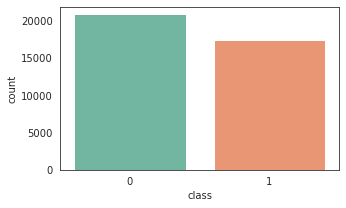

In [39]:
sns.set_style("white")
sns.set_palette('Set2')
fig, ax=plt.subplots(figsize=(5, 3))
ax = sns.countplot(isot_full_df['class'])
fig.show()

Text(0.5, 1.0, 'Distribution of The Subject According to Real and Fake Data')

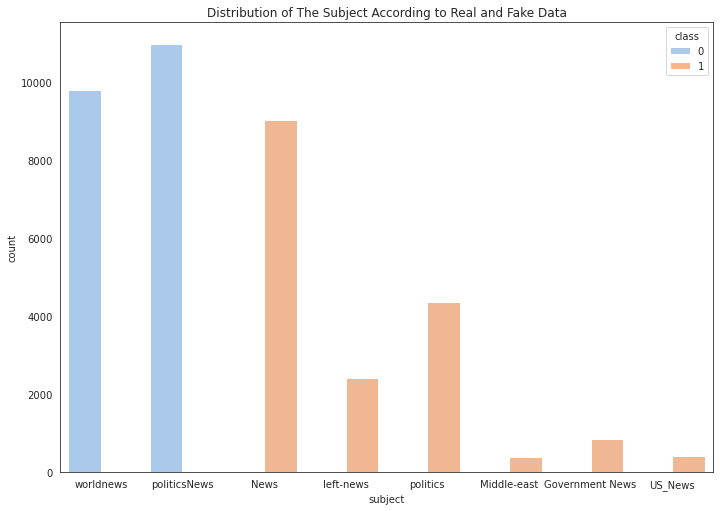

In [40]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
## Distribution of The Subject According to Real and Fake Data
ax = sns.countplot(x="subject",  hue='class', data=isot_full_df, palette="pastel")
plt.title("Distribution of The Subject According to Real and Fake Data")

In [41]:
#real_df.plot(kind='bar',figsize=(20, 10))

#### Title Length Analysis for Real and Fake news

In [42]:
#isot_full_df.head(2)

In [43]:
isot_full_df['title_length']  = isot_full_df['title'].str.len().astype('int')

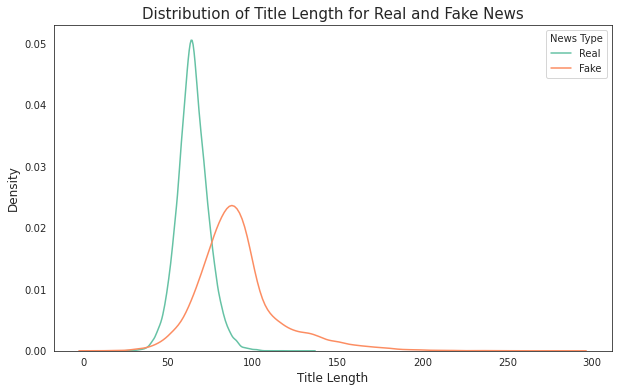

In [44]:
plt.figure(figsize=(10,6))
sns.kdeplot(isot_full_df[isot_full_df['class']==0]['title_length'])
sns.kdeplot(isot_full_df[isot_full_df['class']==1]['title_length'])
plt.xlabel('Title Length',fontsize=12)
plt.ylabel('Density',fontsize=12)
plt.legend(title='News Type',fontsize=10,labels=['Real','Fake'])
plt.title('Distribution of Title Length for Real and Fake News',fontsize=15)
plt.show()

The width of the fake news title length plot distribution is  larger than that of real news.Most of the fake news articles having title length between 60 and greater than 150 when compared witht he real news title length

#### News Body Length Analysis for Real and Fake news

In [45]:
isot_full_df['body_length']  = isot_full_df['text'].str.len().astype('int')

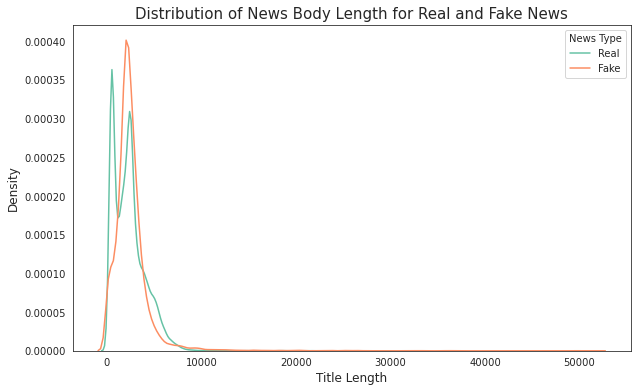

In [46]:
plt.figure(figsize=(10,6))
sns.kdeplot(isot_full_df[isot_full_df['class']==0]['body_length'])
sns.kdeplot(isot_full_df[isot_full_df['class']==1]['body_length'])
plt.xlabel('Title Length',fontsize=12)
plt.ylabel('Density',fontsize=12)
plt.legend(title='News Type',fontsize=10,labels=['Real','Fake'])
plt.title('Distribution of News Body Length for Real and Fake News',fontsize=15)
plt.show()

In [47]:
isot_full_df.head(2)

,title,text,subject,date,class,title_length,body_length
0,Macron vows Caribbean rebuild as anger rises against European powers,"French President Emmanuel Macron vowed to quickly rebuild the islands of the French Caribbean during a visit on Tuesday meant to dispel anger at his government s response to Hurricane Irma, which killed at least 43 people in the region. The clutch of Caribbean islands hardest hit by the storm were mainly overseas territories belonging to Britain, France and the Netherlands, whose tens of thousands of residents are European Union citizens. The U.S. Virgin Islands were also hard hit. European countries and the United States have sent troops to deliver aid and provide security after the storm toppled homes and hospitals, but locals and tourists short of food or shelter say help was slow to arrive. Macron, who is also facing the first test at home of his resolve to reform the economy with a day of protests against his labor reforms, denied that authorities reacted too slowly. Basic services in the region were lost after Irma, weakening law and order, and looting erupted on some island...",worldnews,"September 12, 2017",0,68,3198
1,"Cruz, Rubio say Iran prisoner swap a 'dangerous precedent'","Republican presidential candidates Ted Cruz and Marco Rubio praised Iran’s release of five detained Americans on Sunday, but sharply criticized the deal the White House made to win their freedom saying it would lead to more Americans being taken “hostage.” U.S. President Barack Obama pardoned three Iranian-Americans charged for violating sanctions against Iran, a lawyer for one of the men said, while prosecutors moved to drop charges against four Iranians outside the United States. Iran agreed to free five Americans including Rezaian and Saeed Abedini, an Iranian-American Christian pastor sentenced to eight years in prison in 2013 on charges of undermining Iran’s national security. Cruz, speaking to Fox News Sunday, said, “Praise God that the prisoners are coming home” but Iran got the better end of the prisoner swap. “We released seven terrorists who had helped Iran with their nuclear program, and we agreed not to prosecute another 14 terrorists for doing the same thing. ...",politicsNews,"January 17, 2016",0,58,2571


#### Combining the columns  'title' and 'text'

In [48]:
isot_full_df['fulltext'] = isot_full_df["title"] +' ' + isot_full_df["text"]

##### Saving Combined Dataframe to csv file

In [49]:
isot_full_df.to_csv('Updated//ISOT_Combined_FullData.csv', index=False)

##### Loading the Full dataset from CSV

In [51]:
isot_full_df = pd.read_csv("Updated//ISOT_Combined_FullData.csv")

#### Dropping the columns 'title' , 'text' and 'date'

In [52]:
isot_full_df = isot_full_df.drop(columns = ['title','text', 'subject','date','title_length','body_length','date'])

In [53]:
isot_full_df=isot_full_df.reset_index(drop=True)

In [54]:
isot_full_df.head(2)

,class,fulltext
0,0,"Macron vows Caribbean rebuild as anger rises against European powers French President Emmanuel Macron vowed to quickly rebuild the islands of the French Caribbean during a visit on Tuesday meant to dispel anger at his government s response to Hurricane Irma, which killed at least 43 people in the region. The clutch of Caribbean islands hardest hit by the storm were mainly overseas territories belonging to Britain, France and the Netherlands, whose tens of thousands of residents are European Union citizens. The U.S. Virgin Islands were also hard hit. European countries and the United States have sent troops to deliver aid and provide security after the storm toppled homes and hospitals, but locals and tourists short of food or shelter say help was slow to arrive. Macron, who is also facing the first test at home of his resolve to reform the economy with a day of protests against his labor reforms, denied that authorities reacted too slowly. Basic services in the region were lost af..."
1,0,"Cruz, Rubio say Iran prisoner swap a 'dangerous precedent' Republican presidential candidates Ted Cruz and Marco Rubio praised Iran’s release of five detained Americans on Sunday, but sharply criticized the deal the White House made to win their freedom saying it would lead to more Americans being taken “hostage.” U.S. President Barack Obama pardoned three Iranian-Americans charged for violating sanctions against Iran, a lawyer for one of the men said, while prosecutors moved to drop charges against four Iranians outside the United States. Iran agreed to free five Americans including Rezaian and Saeed Abedini, an Iranian-American Christian pastor sentenced to eight years in prison in 2013 on charges of undermining Iran’s national security. Cruz, speaking to Fox News Sunday, said, “Praise God that the prisoners are coming home” but Iran got the better end of the prisoner swap. “We released seven terrorists who had helped Iran with their nuclear program, and we agreed not to..."


### Stopword Consolidated List preparation

In [55]:
#loading the english language small model of spacy
import spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
len(sw_spacy)

326

In [56]:
gensim_stopwords_list=list(gensim_stopwords) # gensim
nltk_stopwords_list=stopwords.words('english') # nltk
spacy_stopwords=list(sw_spacy) # spacy
wordcloud_stopwords_list=list(STOPWORDS)

In [57]:
total_stop_words_list= set(gensim_stopwords_list + nltk_stopwords_list + spacy_stopwords + wordcloud_stopwords_list)

#### Helper Function to preprocess the text  with all the operations as mentioned above

In [58]:
def clean_format(text):
    # Remove HTML tags
    bsoup = BeautifulSoup(text, "html.parser")
    clean_text = bsoup.get_text()
    
    
    # Remove any URL
    url = re.compile(r'https?://\S+|www\.\S+')
    url.sub(r'', clean_text)
    
    # Remove any numbers
    clean_text=re.sub(r'\d+','',clean_text)
    
    # Remove all kinds of date formats
    clean_text=re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', clean_text)
    clean_text=re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', clean_text)
    clean_text=re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', clean_text)
    
    
    # Removal of punctuation and lower case conversion
    clean_text = re.sub('\[[^]]*\]', ' ', clean_text)
    clean_text = re.sub('[^a-zA-Z]',' ',clean_text)  # replaces non-alphabets with spaces
    clean_text = clean_text.lower()
    
    # Removal of 2 consecutive double space
    clean_text=re.sub(r' {2,}',' ',clean_text)
    
    clean_text = clean_text.split()
    
    textclean=[]
    clean_text = [textclean.append(word) for word in clean_text if word not in total_stop_words_list and len(word) > 2]
    clean_text = ' '.join(textclean)
    
#     # Lemmatization
    clean_text = clean_text.split()
    lemmatizer = WordNetLemmatizer()
    newcleantext= [lemmatizer.lemmatize(w) for w in clean_text]
    newcleantext = ' '.join(newcleantext)
    
    return newcleantext

In [59]:
import time

# get the start time
st = time.time()


#Apply function on text column
isot_full_df['cleaned_fulltext']=isot_full_df['fulltext'].apply(clean_format)
#df2['cleaned_fulltext'] = df2['cleaned_fulltext'].apply(lambda x: x[1:-1])
# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 52.367724895477295 seconds


In [60]:
#isot_full_df.head(2)

#### Saved cleaned dataframe to a csv

In [61]:
isot_full_df.to_csv('Updated//ISOT_Combined_textCleaned_Data.csv', index=False)

#### Loading the cleaned dataset from CSV

In [3]:
isot_full_df = pd.read_csv("Updated//ISOT_Combined_textCleaned_Data.csv")

#### Word Count Analysis for Fake News

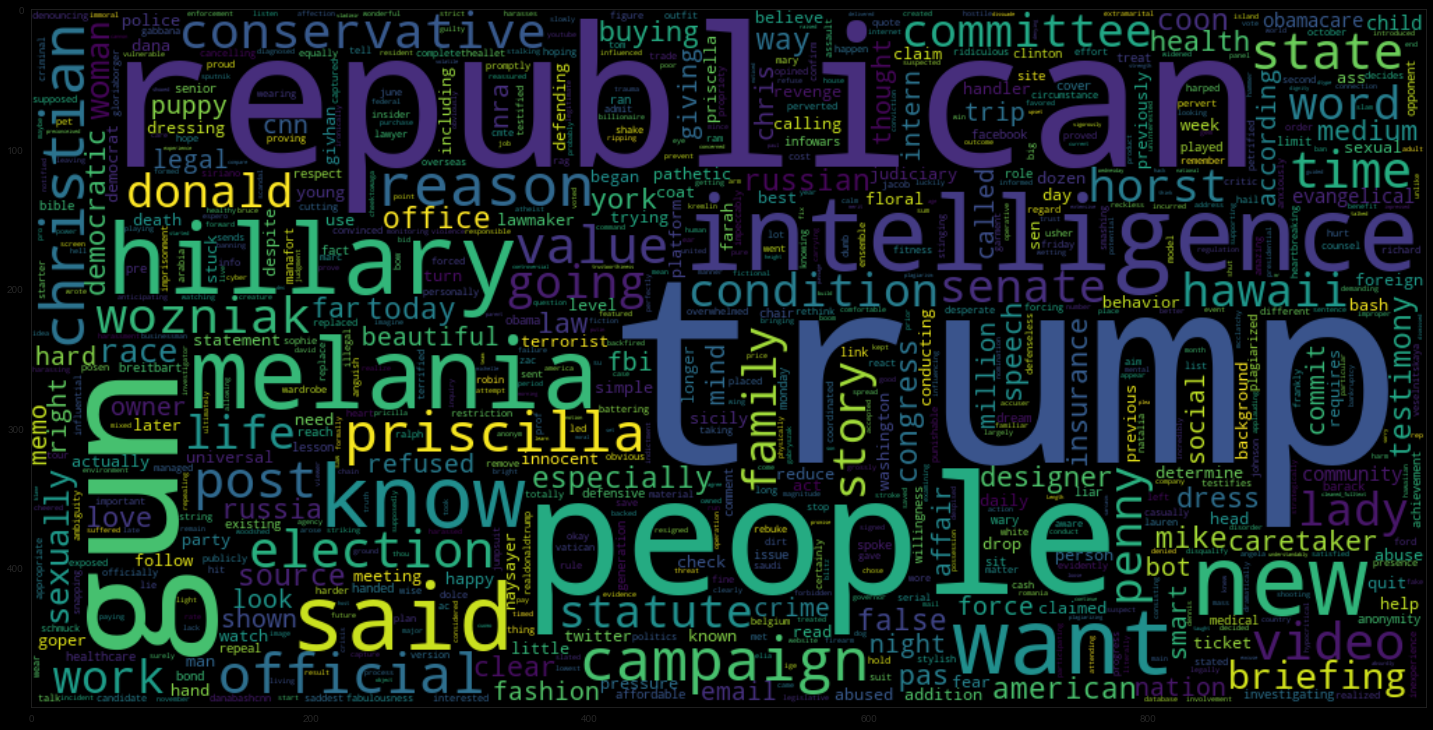

In [53]:
from wordcloud import WordCloud,STOPWORDS

wc = WordCloud(max_words = 2000 , width = 1000 , height = 500 , background_color = 'black',
               stopwords = total_stop_words_list,collocations=False).generate("".join(str(isot_full_df[isot_full_df['class']== 1].cleaned_fulltext)))
fig = plt.figure(
    figsize = (25, 15),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('on')
plt.show()

#### Word Count Analysis for Real News

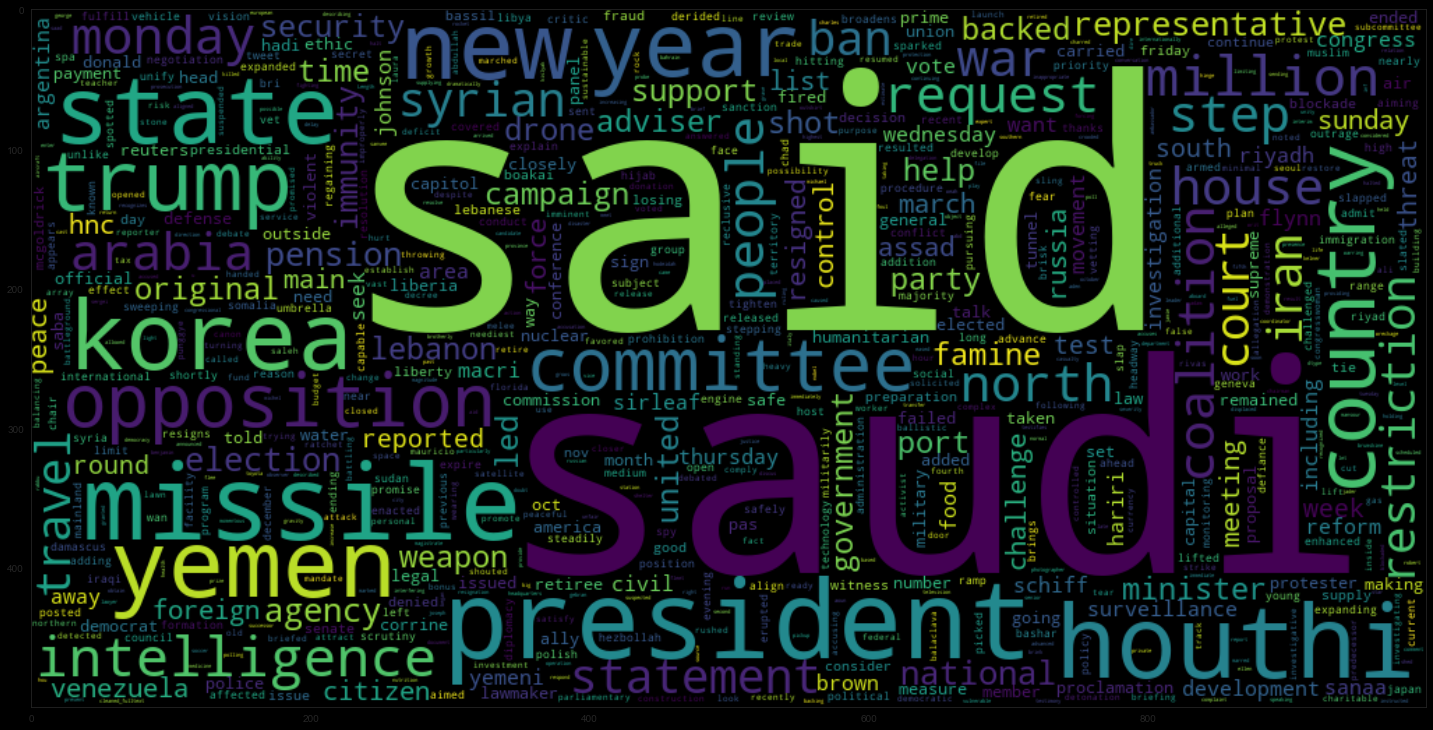

In [54]:
from wordcloud import WordCloud,STOPWORDS

wc = WordCloud(max_words = 2000 , width = 1000 , height = 500 , background_color = 'black',
               stopwords = total_stop_words_list,collocations=False).generate("".join(str(isot_full_df[isot_full_df['class']== 0].cleaned_fulltext)))
fig = plt.figure(
    figsize = (25, 15),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('on')
plt.show()

#### Frequency Count Distribution  for both Fake and Real news

In [55]:
from collections import Counter
from itertools import chain

In [58]:
def frequency_words(words, classnm):
    counter = Counter(chain.from_iterable(words))
    df_freq_word = pd.DataFrame(counter.values(), index = counter.keys(), columns = ['Word_Frequency'])
    df_freq_word.index = df_freq_word.index.set_names(classnm)
    df_freq_word = df_freq_word.sort_values(by = 'Word_Frequency', ascending = False, axis=0)[:30]
    df_freq_word = df_freq_word.pivot_table(columns = classnm)
    df_freq_word = df_freq_word.sort_values(by = 'Word_Frequency', ascending = False, axis=1)
    display(df_freq_word)
    
words_fake = [s.split() for s in isot_full_df.loc[isot_full_df['class'] == 1]['cleaned_fulltext']]
words_real = [s.split() for s in isot_full_df.loc[isot_full_df['class'] == 0]['cleaned_fulltext']]
frequency_words(words_fake, 'Fake')
frequency_words(words_real, 'Real')

Fake,trump,said,president,people,state,donald,republican,obama,time,clinton,year,image,american,right,hillary,white,new,news,video,know,twitter,woman,campaign,house,country,america,featured,medium,want,think
Word_Frequency,76206,24928,22086,21618,17456,16116,15459,15073,14868,14685,14270,14155,13798,12197,11418,11252,11031,10854,10203,9984,9841,9717,9555,8955,8684,8651,8520,8310,8303,8220


Real,said,trump,state,president,republican,year,government,house,new,party,people,election,united,official,told,country,campaign,group,court,leader,week,security,donald,clinton,white,tax,north,percent,obama,law
Word_Frequency,96019,57715,36973,28076,23182,22204,19755,17870,16285,15297,15025,14991,14561,14492,13815,13622,11147,11014,10890,10733,10541,10340,10153,10087,10054,10037,9950,9891,9806,9754


In [60]:
#isot_full_df.head(2)

### Count of Words for each row text

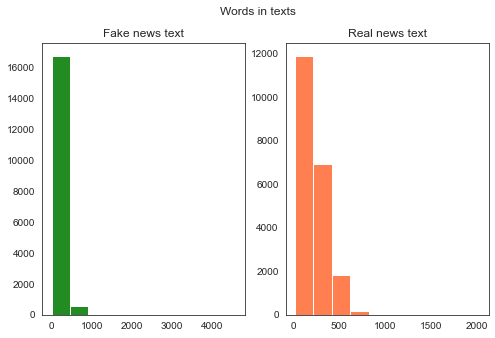

In [61]:
#https://matplotlib.org/3.5.0/gallery/color/named_colors.html
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,5))
text_len=isot_full_df[isot_full_df['class']==1]['cleaned_fulltext'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='forestgreen')
ax1.set_title('Fake news text')
text_len=isot_full_df[isot_full_df['class']==0]['cleaned_fulltext'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='coral')
ax2.set_title('Real news text')
fig.suptitle('Words in texts')
plt.show()

Around 500 to 1000 words are common words present in fake news category , Meanwhile, around 250 words are most frequent in real news category and total around only 500 words common in real news

### Analysis of n-gram  for fake and real news articles

In [62]:
real_texts=' '.join(isot_full_df.loc[isot_full_df['class'] == 0]['cleaned_fulltext'])
fake_texts=' '.join(isot_full_df.loc[isot_full_df['class'] == 1]['cleaned_fulltext'])

In [64]:
fake_texts = re.sub('\[[^]]*\]', ' ', fake_texts)
fake_texts = re.sub('[^a-zA-Z]',' ',fake_texts)  # replaces non-alphabets with spaces
fake_texts=re.sub(r' {2,}',' ',fake_texts)

real_texts = re.sub('\[[^]]*\]', ' ', real_texts)
real_texts = re.sub('[^a-zA-Z]',' ',real_texts)
real_texts=re.sub(r' {2,}',' ',real_texts)


fake_string = fake_texts.strip(" ").split(" ")
real_string = real_texts.strip(" ").split(" ")

In [65]:
def plot_n_gram(string,i):
    n_gram = (pd.Series(nltk.ngrams(string, i)).value_counts())[:15]
    n_gram_df=pd.DataFrame(n_gram)
    n_gram_df = n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    print(n_gram_df.head())
    plt.figure(figsize = (16,9))
    return sns.barplot(x='count',y='word', data=n_gram_df)

#### Unigram Analysis

            word  count
0        (said,)  96019
1       (trump,)  57715
2       (state,)  36973
3   (president,)  28076
4  (republican,)  23182


<AxesSubplot:xlabel='count', ylabel='word'>

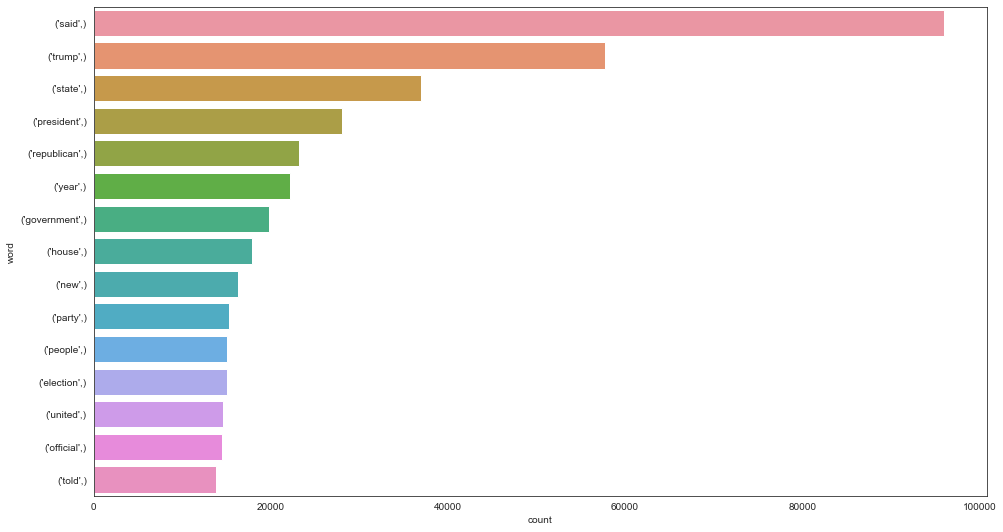

In [66]:
plot_n_gram(real_string,1)

           word  count
0      (trump,)  76206
1       (said,)  24928
2  (president,)  22086
3     (people,)  21618
4      (state,)  17456


<AxesSubplot:xlabel='count', ylabel='word'>

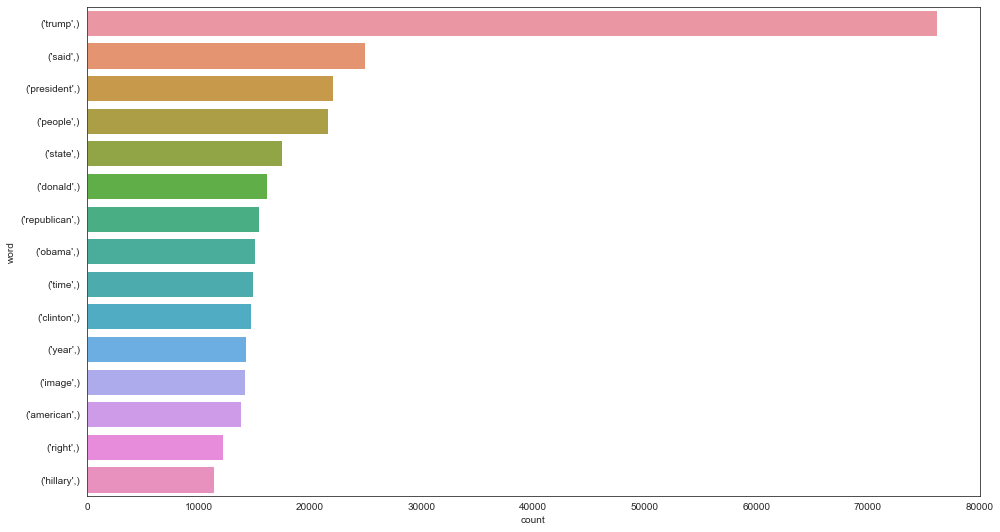

In [67]:
plot_n_gram(fake_string,1)

From the above unigram analysis, we can understood that , most of the fake news appeared related to political news especially related with donald trump news 

#### Bigram Analysis

                  word  count
0      (united, state)  11527
1      (donald, trump)   9868
2       (white, house)   8880
3       (north, korea)   5755
4  (president, donald)   5655


<AxesSubplot:xlabel='count', ylabel='word'>

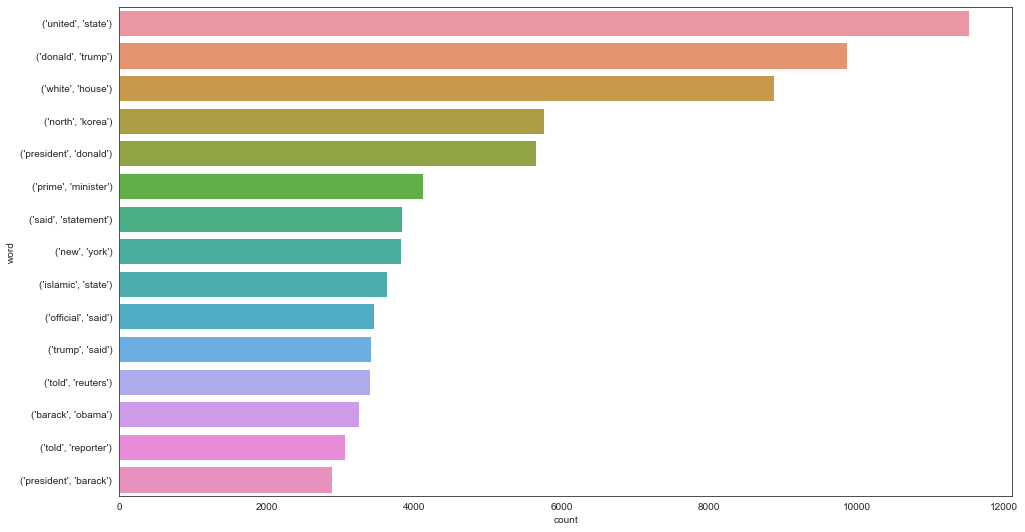

In [68]:
plot_n_gram(real_string,2)

                 word  count
0     (donald, trump)  14815
1   (featured, image)   8058
2  (hillary, clinton)   5732
3      (white, house)   5453
4     (united, state)   4978


<AxesSubplot:xlabel='count', ylabel='word'>

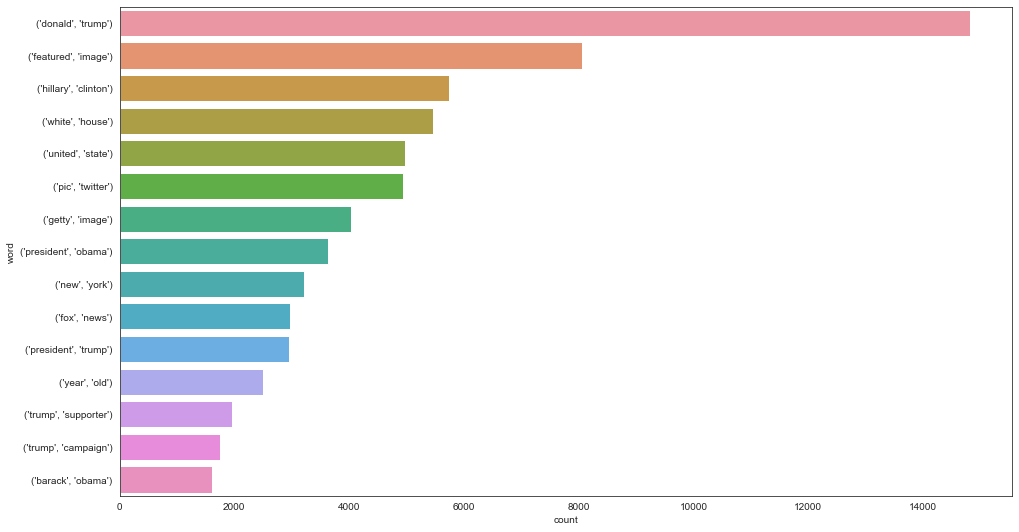

In [69]:
plot_n_gram(fake_string,2)

In [71]:
isot_full_df.head(2)

,class,fulltext,cleaned_fulltext
0,1,"Republican Insiders Are Taking Aim At Trump, Calling On Pence To Drop Out Now that it s been exposed that Donald Trump is a serial pervert who sexually assaults women, Republicans are desperate to get him out of the race and promptly replaced by another GOPer who, you know, doesn t casually admit to forcing himself onto women.Well it s harder said than done. First, the rules make it very hard to remove someone and replace them especially with four weeks left until the election. Second, Trump has already stated that he would not bow out of the race under any circumstances.Even though dozens of influential Republican lawmakers and figures want him out, they are stuck with him unless he decides to personally call it quits.So what s plan B? Well, for starters, they want Mike Pence to drop off the ticket in an effort to pressure Trump to follow suit.According to CNN s Dana Bash:Sources tell @GloriaBorger some republicans want @mike_pence to quit the ticket in order to pressure @realD...",republican insider taking aim trump calling penny drop exposed donald trump serial pervert sexually assault woman republican desperate race promptly replaced goper know casually admit forcing woman harder said rule hard remove replace especially week left election second trump stated bow race circumstance dozen influential republican lawmaker figure want stuck decides personally quits plan starter want mike penny drop ticket effort pressure trump follow suit according cnn dana bash source tell gloriaborger republican want mike penny quit ticket order pressure realdonaldtrump dana bash danabashcnn october word republican hoping use mike penny battering ram force pathetic perverted candidate race usher equally pathetic hail mary save ass republican especially placed hope trump officially saddest lot american politics cutting cash force cancelling mike penny campaign stop publicly denouncing stinging rebuke republican realized shake thought way hit hurt man supposed matter republican ...
1,1,"Don Trump Jr. Testified To The Senate Today And They Don’t Seem To Believe A Word He Said Donald Trump, Jr. went before Congress today to give yet another version of his reasons for meeting with a Russian lawyer in June of 2016. While he did actually confirm what he said in the email string he was dumb enough to post to Twitter that he met with Natalia Veselnitskaya because she claimed to have dirt on Hillary he gave a ridiculous reason for it. His reason was that he was trying to determine Hillary s fitness for office, because that s a totally innocent reason that makes it all okay.So that makes it all innocent, especially because he also claimed that he was just so overwhelmed with the campaign due to inexperience, but he did still evidently have the presence of mind to know he should talk to legal counsel about the propriety of the meeting and info, or so his claim goes.Some, however, on the Senate Judiciary Committee don t believe him, it seems. Sen. Chris Coons, who sits on t...",trump testified senate today believe word said donald trump went congress today version reason meeting russian lawyer june actually confirm said email string dumb post twitter met natalia veselnitskaya claimed dirt hillary gave ridiculous reason reason trying determine hillary fitness office totally innocent reason make okay make innocent especially claimed overwhelmed campaign inexperience evidently presence mind know talk legal counsel propriety meeting info claim go senate judiciary committee believe sen chris coon sits committee sent memo interested party testimony today complete statute giving false testimony congress ambiguity memo say statute mind regard donald trump testimony today quote statute state illegal lie congress coon say important remember testifies senate committee restriction false statement statute say material false statement congress criminal punishable fine imprisonment read coon memo testimony senate judiciary cmte sen c

## Model Building

#### Splitting Data into Train and Test Datasets

In [4]:
X=isot_full_df['cleaned_fulltext']
y=isot_full_df['class']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=0)

#### Creating Pipeline using  TF-IDF Vectorizer using one gram

In [6]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [7]:
X_train_tfidf.shape

(30616, 93666)

### Helper Functions

In [8]:
import timeit
from timeit import default_timer as timer
from datetime import timedelta
 


def metrics(X_test,y_test,clf):
    predictions=clf.predict(X_test)
    #predictions=(clf.predict_proba(X_test)[:,1] >= 0.3).astype(bool)
    print("confusion_matrix :")
    print(confusion_matrix(y_test,predictions))
    print("Accuracy Score :")
    print(accuracy_score(y_test, predictions))
    print("Classification Report :")
    print(classification_report(y_test, predictions))
    print("F1 score :")
    print(f1_score(y_test, predictions))
    print("ROC AUC Score")
    y_pred_proba = clf.predict_proba(X_test)
    print(roc_auc_score(y_test, y_pred_proba[:,1]) )
    print("------------------------------")

    
def model_comparison_table(X_test,y_test,classifier_list):
    dict_clf={}
    for clf_name,clf in classifier_list:
        predictions=clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)
        accuracy=accuracy_score(y_test, predictions)
        precision=precision_score(y_test,predictions,average='macro').round(2)
        recall=recall_score(y_test,predictions)
        f1score=f1_score(y_test,predictions).round(2)
        ROC_AUC=roc_auc_score(y_test, y_pred_proba[:,1])
        dict_clf[clf_name]=[accuracy,precision,recall,f1score,ROC_AUC]
    df_models_scores = pd.DataFrame(dict_clf, index=['Accuracy', 'Precision', 'Recall', 'F1 Score','roc_auc_score'])
    return df_models_scores

## Random Forest

In [11]:
rf_clf=RandomForestClassifier(random_state=0)

In [12]:
rf_clf.fit(X_train_tfidf,y_train)

pred = rf_clf.predict(X_test_tfidf)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))

Accuracy score : 0.9678599425137183
Confusion matrix : 
 [[4107   57]
 [ 189 3301]]


In [13]:
print("Classification Report")
print(classification_report(y_test, pred))

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      4164
           1       0.98      0.95      0.96      3490

    accuracy                           0.97      7654
   macro avg       0.97      0.97      0.97      7654
weighted avg       0.97      0.97      0.97      7654



### Support Vector Machine

In [9]:
svm_clf=SVC(random_state=0,probability=True)

In [10]:
svm_clf.fit(X_train_tfidf,y_train)

pred = svm_clf.predict(X_test_tfidf)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))

Accuracy score : 0.9830154167755422
Confusion matrix : 
 [[4116   48]
 [  82 3408]]
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4164
           1       0.99      0.98      0.98      3490

    accuracy                           0.98      7654
   macro avg       0.98      0.98      0.98      7654
weighted avg       0.98      0.98      0.98      7654



## KNN

In [14]:
#Create KNN Object.
knn_clf = KNeighborsClassifier()

In [15]:
knn_clf.fit(X_train_tfidf,y_train)

pred = knn_clf.predict(X_test_tfidf)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))

Accuracy score : 0.8573295009145545
Confusion matrix : 
 [[3949  215]
 [ 877 2613]]
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      4164
           1       0.92      0.75      0.83      3490

    accuracy                           0.86      7654
   macro avg       0.87      0.85      0.85      7654
weighted avg       0.87      0.86      0.86      7654



### Xgboost

In [16]:
#Create KNN Object.
xg_clf=XGBClassifier(random_state=0)

xg_clf.fit(X_train_tfidf,y_train)

pred = xg_clf.predict(X_test_tfidf)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))


Accuracy score : 0.983799320616671
Confusion matrix : 
 [[4123   41]
 [  83 3407]]
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4164
           1       0.99      0.98      0.98      3490

    accuracy                           0.98      7654
   macro avg       0.98      0.98      0.98      7654
weighted avg       0.98      0.98      0.98      7654



### Naiva Bayes

In [17]:
nb_clf=MultinomialNB()

nb_clf.fit(X_train_tfidf.todense(),y_train)

pred = nb_clf.predict(X_test_tfidf.todense())
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))

Accuracy score : 0.9318003658217925
Confusion matrix : 
 [[3992  172]
 [ 350 3140]]
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      4164
           1       0.95      0.90      0.92      3490

    accuracy                           0.93      7654
   macro avg       0.93      0.93      0.93      7654
weighted avg       0.93      0.93      0.93      7654



#### Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
logticreg_clf=LogisticRegression()

logticreg_clf.fit(X_train_tfidf.todense(),y_train)

pred = logticreg_clf.predict(X_test_tfidf.todense())
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))

Accuracy score : 0.977136137967076
Confusion matrix : 
 [[4100   64]
 [ 111 3379]]
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4164
           1       0.98      0.97      0.97      3490

    accuracy                           0.98      7654
   macro avg       0.98      0.98      0.98      7654
weighted avg       0.98      0.98      0.98      7654



### Consolidating all classifiers accuracy scores

In [19]:
classifiers = [('Logistic Regression',logticreg_clf),('Naive Bayes',nb_clf),('Xgboost',xg_clf),
              ('KNN',knn_clf),('Random Forest',rf_clf),("SVM",svm_clf)]

In [20]:
df_model_scores=model_comparison_table(X_test_tfidf,y_test,classifiers)
df_model_scores.head(20).T.sort_values(by='Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1 Score,roc_auc_score
Xgboost,0.983799,0.98,0.976218,0.98,0.997884
SVM,0.983015,0.98,0.976504,0.98,0.997932
Logistic Regression,0.977136,0.98,0.968195,0.97,0.997006
Random Forest,0.967860,0.97,0.945845,0.96,0.996107
Naive Bayes,0.931800,0.93,0.899713,0.92,0.980943
KNN,0.857330,0.87,0.748711,0.83,0.936020
